# Simulated Annealing

A simple Simulated Annealing solver in Python

Of course this implementation is not very efficient, but it is a good starting point for understanding Simulated Annealing for Ising Models.

In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt

Here we want to use the following Energy configuration

$$
E = \sum_{i} h_i s_i + \sum_{i < j} J_{ij} s_i s_j,
$$
where $s_i$ is the $i$-th spin, $h$ is the bias vector and $J$ is the coupling matrix

In [2]:
# define the Hamiltonian
def Energy(h,J,s):
    E =  h.T @ s + s.T @ J @ s
    return E

for the Metropolis-Hastings algorithm we need to calculate the variation in Energy. The following implementation is the most general. However, most of the time the topology of the problem, i.e. how the matrix $J$ is structured, allows to compute $\Delta E$ in a more efficient way.

In [3]:
def DeltaEnergy(s, s_new, h, J):
    dE = Energy(h, J, s_new) - Energy(h,J,s)
    return dE

This function randomly prepares the initial state

In [4]:
def PrepareInitialState(L):
    a = np.random.binomial(1,.5, L*L)
    a[np.where(a==0)] = -1
    return a

Let's define three different types of annealing schedules.

In [5]:
# linear temperature schedule
def LinearTemperatureSchedule(n_temp, tmax, tmin):
    temperature = np.zeros(n_temp)
    for i in range(n_temp):
        temperature[i] = tmax - i*(tmax-tmin)/(n_temp-1)
    return temperature

def ExponentialTemperatureSchedule(tmax, tmin, factor):
    temperature = []
    temperature.append(tmax)
    this_t = tmax
    while this_t > tmin:
        this_t = temperature[-1]*factor
        temperature.append(this_t)
    return np.array(temperature)

def LogarithmicTemperatureSchedule(n_temp):
    temperature  = []
    for i in range(n_temp):
        temperature.append(1.0/(np.log(i+1)+1))
    
    return np.array(temperature)
        

Here we define the Metropolis-Hastings sweep

In [6]:
# define the metropolis sweep
def metropolis(s,J,h,L,T):
    # do L steps
    for i_spin in range(L):
        this_s = np.random.randint(0,L)
        new_s = s.copy()
        new_s[this_s] = -s[this_s]
        dE = DeltaEnergy(h=h,J=J,s=s,s_new=new_s)
        if (np.exp(-dE/T) >= np.random.rand()):
            return new_s
        else:
            return s 

and here the SA implementation

In [7]:
def SimulatedAnnealing(temperature, n_steps, J,h,L):
    #initialize a state:
    s = PrepareInitialState(L)
    for T in temperature:
        # equilibrate
        for step in range(n_steps):
            s = metropolis(s=s, J=J,h=h,L=L,T=T)

        #print('T, Energy:', T, Energy(h=h,J=J,s=s)) 
    
    return s,Energy(h=h,J=J,s=s)

Here we define the sampling using the simulated annealing

In [8]:
def SamplesFromAnnealing(temperature, n_steps, J,h,L, n_samples=100, feedback = 0):
    s = []
    E = []
    for i_step in range(n_samples):
        s_this,E_this =  SimulatedAnnealing(temperature,n_steps, J,h,L)
        
        s.append(s_this)
        E.append(E_this)
        
        if feedback>0:
            print('step:', i_step, 'current_min',min(E))

        
    return s,np.array(E)

## Building the problem

### Problem 1

Here we fix the problem parameters:

In [9]:
# some parameters
L = 4

In [10]:
# define the biases
h = np.zeros(L*L)

In [11]:
# define the couplings
J = np.zeros((L*L,L*L))

In [12]:
# if the other couplings are 1.. I don't remember
for i in range(L*L-1):
    if (i+1) % L != 0:
        J[i,i+1] = 1
    if i < L*(L-1):
        J[i,i+L] = 1
    

In [13]:
# Set the non-zero couplings
J[2,6] = -1.0
J[5,9] = -1.0
J[10,14] = -1.0

## Visualizations.

Here we want to plot the problems we are trying to solve.

In [14]:
def DrawProblem(L,h,J):
    # coordinates of the spins
    fig = plt.figure(figsize = (5,5))
    spins_x = np.array([[i for j in range(L)] for i in range(L)]).flatten()
    spins_y = np.array([[i for i in range(L)] for j in range(L)]).flatten()
    
    
    # now draw the lines
    for i in range(L*L):
        for j in range(L*L):
            if J[i,j] != 0 :
                if J[i,j] > 0:
                    color = 'red'
                    lw = 1
                    ls = '-'
                    z = 2
                else:
                    if (J[i,j] <= -1):
                        lw = 1.5
                        ls = '-'
                    else: 
                        lw = 1
                        ls = '--'
                        
                    color = 'black'
                    z = 1
                
                points_x = [spins_x[i],spins_x[j]]
                points_y = [spins_y[i],spins_y[j]]
                
                plt.plot(points_x, points_y, color=color, linewidth = lw, linestyle = ls, zorder=z)
                
    colors = [ 'grey' for i in range(L*L)]
    for i in range(L*L):
        if h[i] > 0:
            colors[i] = 'red'
        elif h[i] < 0:
            colors[i] = 'magenta'
    
    plt.scatter(spins_x, spins_y, marker = 'o', color = colors, zorder = 3, s = 50)
                
    
    plt.show()

Let's draw the problem: the blue thin lines represent positive (+1) couplers, $J_{ij} = 1$ between the spins, while the thick red lines represent negative couplers between the spins $J_{ij} = -1$.

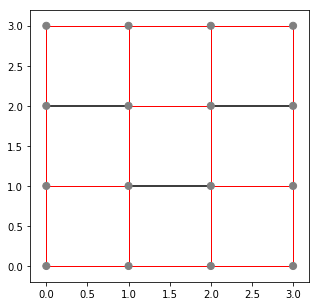

In [15]:
DrawProblem(L,h=h,J=J)

## Problem 2

For now let's work with problem 2. Found on https://arxiv.org/pdf/1606.06833.pdf

In [16]:
L = 4

In [17]:
h = np.zeros(L*L)

In [158]:
delta = -1

In [159]:
# Define the biases!
red = [0,3,4,7,8,11,12,15]
magenta = [1,5,6,10,13,14]
grey = [2,9]

In [160]:
# set the positive and negative biases
h[red] = 1
h[magenta] = -1

In [161]:
# set the dashed ()
dashed = [np.array([0,0,3,3,8,8,11,11]),
         np.array([4,7,4,7,12,15,12,15])]

In [162]:
solid = [np.array([0,1,1,1,2,2,2, 2,4,6,8, 9, 9,10,10,10,12,14]),
        np.array([1,5,6,9,3,5,6,10,5,7,9,13,14,11,13,14,13,15])]

In [163]:
J = np.zeros((L*L,L*L))

In [167]:
J[dashed] = - delta

In [168]:
J[solid] = -1.0

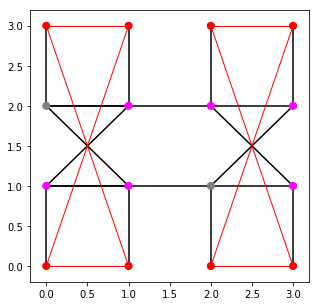

In [169]:
DrawProblem(L,h=h,J=J)

Let's also plot the annealing schedule,

In [170]:
def DrawTemperature(temperature):
    plt.plot(np.arange(temperature.shape[0]), temperature)
    plt.xlabel('Annealing Step')
    plt.ylabel(r'$k_B T$')
    plt.show()

define a function to plot the solutions,

In [171]:
def DrawSolution(spins):
    fig = plt.figure(figsize = (5,5))
    spins_x = np.array([[i for j in range(L)] for i in range(L)]).flatten()
    spins_y = np.array([[i for i in range(L)] for j in range(L)]).flatten()
    
    for i in range(spins.shape[0]):
        if spins[i]>0:
            color = 'C0'
            marker = '^'
        else:
            color = 'red'
            marker = 'v'
            
        x = spins_x[i]
        y = spins_y[i]
        plt.scatter(x, y, marker = marker, color = color, s = 50 )
    plt.show()


and a function to plot the Energy histogram

In [172]:
def PlotEnergyHistogram(E):
    # fixed bin size
    bins = np.arange(min(E),max(E), 1) # fixed bin size
    plt.xlim([min(E)-2, max(E)+2])
    plt.hist(E, bins=bins, alpha=0.5, )
    plt.title('Energy distribution')
    plt.xlabel('Energy')
    plt.ylabel('# of solutions provided')
    plt.show()

## 1. Exact Method
Since this problem is small we can quickly explore all the different states:

In [173]:
import itertools
lst = list(map(list, itertools.product([-1, 1], repeat=L*L)))

there are 

In [174]:
len(lst)

65536

different states. Let's calculate the energy for each state

In [175]:
E_exact = []
for s in lst:
    this_s = np.array(s)
    E_exact.append(Energy(h,J,this_s))

In [176]:
Emin=np.min(E_exact)

In [177]:
Emin

-24.0

There are 

In [178]:
np.where(E_exact==Emin)[0].shape[0]

4

ground states. Let's print them

In [179]:
minima_exact=np.where(E_exact==Emin)[0]

In [180]:
minima_exact

array([28527, 28662, 63087, 63222])

In [181]:
for m in minima_exact:
    print(lst[m])

[-1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1]
[-1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1]
[1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1]
[1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1]


Let's visualize the ground states

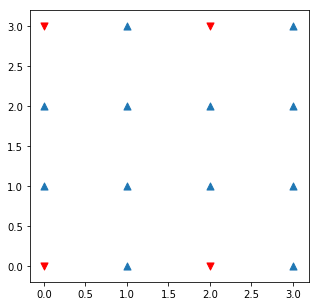

In [182]:
DrawSolution(np.array(lst[minima_exact[0]]))

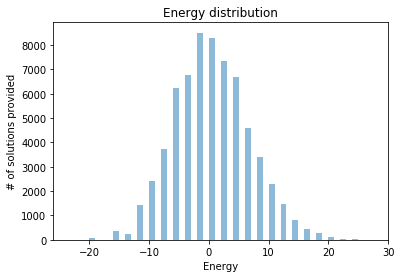

In [183]:
PlotEnergyHistogram(E_exact)

## 2. Drawing samples from annealing.

Here we try to generate some samples from Simulated Annealing. They should ideally be close to the ground state

## 2.1. Exponential temperature schedule

In [184]:
temperature = ExponentialTemperatureSchedule(tmax=5,tmin=0.01,factor=0.8)

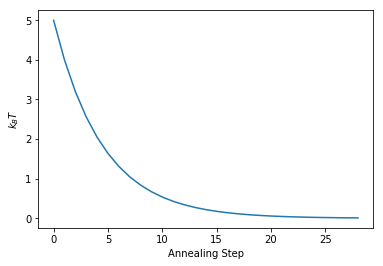

In [185]:
DrawTemperature(temperature)

In [186]:
s_exp,E_exp=SamplesFromAnnealing(temperature=temperature,  # temperatures schedule
                         n_steps=1,        # M-H steps for each temperature
                         J=J,h=h,L=L,      # parameters of the problem
                         n_samples=50000,   # how many samples to draw
                         feedback=0)

In [187]:
minE=np.min(E_exp)
minE

-24.0

In [188]:
# number of minima found
np.where(E_exp==minE)[0].shape[0]

48

In [189]:
minima=np.where(E_exp==minE)[0]

In [190]:
for m in minima:
    print(s_exp[m])

[ 1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1]
[-1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1]
[ 1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1]
[-1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1]
[-1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1]
[ 1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1]
[ 1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1]
[-1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1]
[ 1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1]
[-1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1]
[ 1  1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1 -1]
[-1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1]
[-1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1]
[ 1  1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1 -1]
[-1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1]
[-1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1]
[ 1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1]
[ 1  1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1 -1]
[ 1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1]
[ 1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1]


In [191]:
np.where(E_exp==minE)[0]

array([  136,   138,  2939,  6292,  6859,  7382,  7593,  8218, 10618,
       11791, 12301, 13557, 13845, 14553, 16136, 16360, 19159, 19731,
       21421, 22167, 22623, 23340, 23511, 23750, 23902, 24467, 24831,
       25117, 25280, 25633, 27016, 27053, 28821, 28899, 32631, 35142,
       36642, 38307, 40039, 40426, 40735, 41352, 41556, 42483, 44552,
       44630, 46174, 46310])

Let's draw on of the minimal solutions.

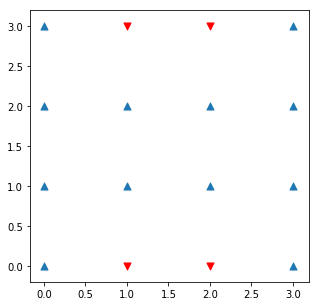

In [192]:
DrawSolution(s_exp[np.where(E_exp==minE)[0][0]])

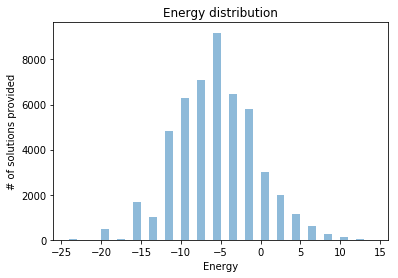

In [193]:
PlotEnergyHistogram(E_exp)

## 2.2. Linear temperature schedule

In [194]:
temperature = LinearTemperatureSchedule(n_temp=10,tmax=5,tmin=0.01)

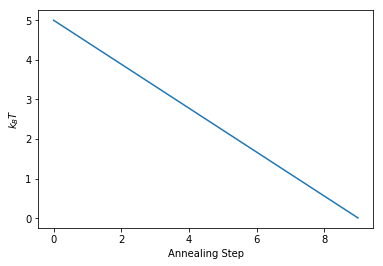

In [195]:
DrawTemperature(temperature)

In [85]:
s_lin,E_lin=SamplesFromAnnealing(temperature=temperature,  # temperatures schedule
                         n_steps=1,               # M-H steps for each temperature
                         J=J,h=h,L=L,              # parameters of the problem
                         n_samples=50000,          # how many samples to draw
                         feedback=0)

/Users/alexzucca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


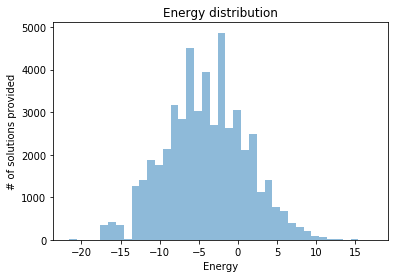

In [86]:
PlotEnergyHistogram(E_lin)

## 2.3. Logarithmic Temperature Schedule

In [60]:
temperature = LogarithmicTemperatureSchedule(n_temp=10)

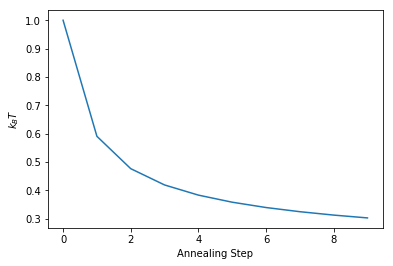

In [61]:
DrawTemperature(temperature)

In [62]:
s_log,E_log=SamplesFromAnnealing(temperature=temperature,  # temperatures schedule
                         n_steps=1,               # M-H steps for each temperature
                         J=J,h=h,L=L,              # parameters of the problem
                         n_samples=10000,          # how many samples to draw
                         feedback=0)

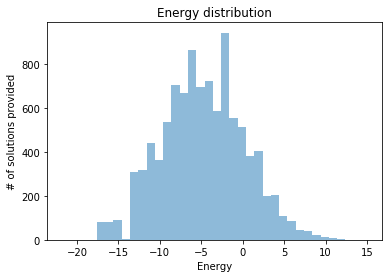

In [63]:
PlotEnergyHistogram(E_log)

## 2.4. Constant Temperature

This is not optimized for now.

In [64]:
s_const,E_const=SamplesFromAnnealing(temperature=[0.01],      # temperatures schedule
                         n_steps=10000,               # M-H steps for each temperature
                         J=J,h=h,L=L,              # parameters of the problem
                         n_samples=100,          # how many samples to draw
                         feedback=0)

/Users/alexzucca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


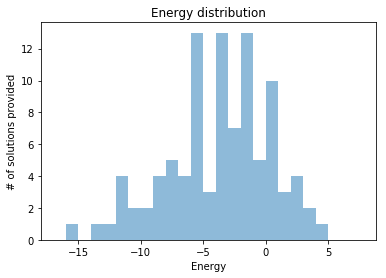

In [65]:
PlotEnergyHistogram(E_const)

The constant temperature teramlization did not find the ground state, but the implementation is not correct

## Investigating some distributions visually

In [66]:
from scipy.optimize import curve_fit

Below we define the function
$$
p(E) = A e^{-\beta E},
$$
that we fit on the histogram of the normalized energy distribution obtained for each temperature schedule. Since the problem is small, we computed all the energy states and in the function ``NormalizedHistogram`` we normalize the counts for each energy by its degeneracy. This helps to visualize the Boltzmann (or Gibbs) distribution above.

In [67]:
def BoltzFunctNoDeg(E,a,b):
    return a*np.exp(-b*E)

In [68]:
def NormalizedHistogram(E,E_exact):
    # find the different values
    E_val = np.unique(E_exact)

    # calculate the degeneracy of the energy ground states
    E_deg = []
    for e in E_val:
        deg = np.where(E_exact == e)[0].shape[0]
        #print(e, deg)
        E_deg.append(deg)
        
    # count the states
    E_count = []
    for e,deg in zip(E_val,E_deg):
        count = np.where(E == e)[0].shape[0]
        #print(e, deg)
        E_count.append(count/deg)
        
    #optimize the funtion
    popt,pcov = curve_fit(f=BoltzFunctNoDeg, xdata=E_val, ydata=E_count)

    # get kT
    kt = 1./popt[1]
    
    # now plotting
    fig = plt.figure(figsize = (5,3.5))
    ax = fig.add_axes([0,0,1,1])
    plt.title('Energy normalized by degeneracy')
    ax.bar(E_val, E_count, alpha = 0.5)
    ax.plot(E_val, BoltzFunctNoDeg(E_val,*popt), color = 'C1')
    ax.text(0.9, 0.9, r'$k_B T$: '+str(kt),
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
    ax.set_xlabel('Energy')
    ax.set_ylabel('count/degenarcy')
    plt.show()

Plot some normalized histograms

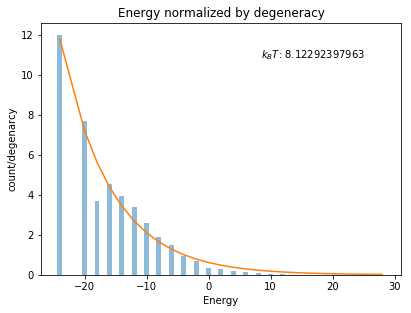

In [196]:
NormalizedHistogram(E=E_exp, E_exact=E_exact)

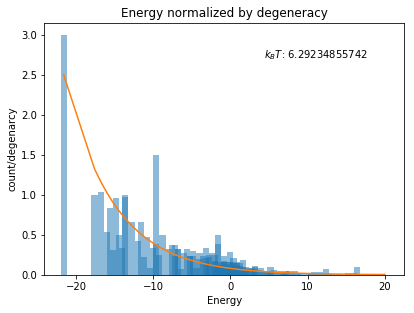

In [82]:
NormalizedHistogram(E=E_lin, E_exact=E_exact)

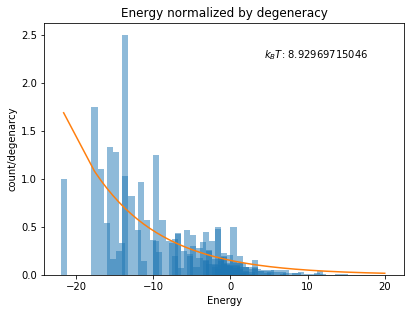

In [87]:
NormalizedHistogram(E=E_log, E_exact=E_exact)

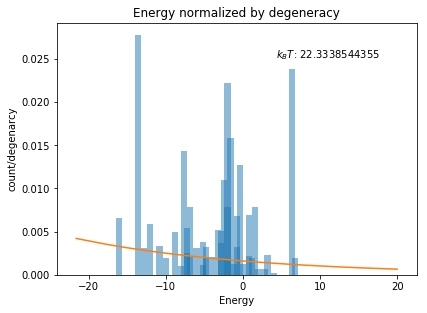

In [88]:
NormalizedHistogram(E=E_const, E_exact=E_exact)

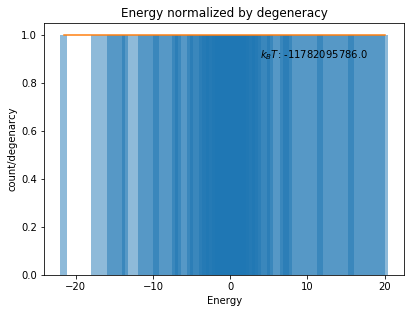

In [89]:
NormalizedHistogram(E=E_exact, E_exact=E_exact)